In [1]:
import os
from torch.utils.data import DataLoader, Dataset

%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, utils, datasets
from PIL import Image
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

E:\Anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(128), # To fit popular models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507], std=[0.245]),
    # transforms.Normalize(mean=[0.507, 0.507, 0.507], std=[0.245,0.245,0.245]),
])

In [9]:
# Hilbert Transform Dataset
train_dataset = datasets.ImageFolder(root="./HilbertTrans/Hilbert_images_128/train",
                              transform=data_transform)

train_datasets_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)

test_dataset = datasets.ImageFolder(root="./HilbertTrans/Hilbert_images_128/test",
                              transform=data_transform)
test_datasets_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)

In [10]:
print('The length of trainset:', train_dataset.__len__())
print('The length of testset:', test_dataset.__len__())

The length of trainset: 2800
The length of testset: 1200


In [11]:
image, label = train_dataset[0]
print(image.shape)
print(label)
image

torch.Size([1, 128, 128])
0


tensor([[[ 0.5076, -2.0694, -2.0694,  ..., -2.0694, -2.0534, -1.6212],
         [-2.0214, -2.0694, -2.0694,  ..., -2.0694, -2.0534, -2.0054],
         [-2.0534, -2.0694, -2.0694,  ..., -2.0694, -1.9253, -1.7012],
         ...,
         [-1.2371, -1.0610, -0.3087,  ..., -1.9093, -2.0694, -2.0534],
         [-1.1410, -0.6608, -0.4848,  ..., -2.0534, -2.0534, -1.8133],
         [-0.5808, -0.8049, -0.3567,  ..., -2.0694, -2.0694, -1.8453]]])

In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [13]:
from cgi import test
from tqdm import tqdm
import itertools
from sklearn.metrics import confusion_matrix,f1_score

def plot_confusion_matrix(y_true,
                          y_pred, 
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    
    cm = confusion_matrix(y_true, y_pred)
    accuracyM = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracyM

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracyM, misclass))
    plt.show()

In [14]:
N_test=len(test_dataset)

def train_model(n_epochs, cost_list, acc_list):
    for epoch in range(n_epochs):
        COST=0
        for x, y in tqdm(train_datasets_loader):
            x=x.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            cost = loss.data
            COST += float(cost.to("cpu"))
        
        cost_list.append(COST)
        correct=0
        
        #perform a prediction on the test data  
        test_y_trues,test_y_preds = [],[]
        for x_test, y_test in test_datasets_loader:
            test_y_trues.extend(y_test.numpy())
            x_test= x_test.to(device)
            y_test= y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            test_y_preds.extend(yhat.to("cpu").numpy())
            correct += (yhat == y_test).sum().item()
            
        accuracy = correct / N_test
        acc_list.append(accuracy)
        
        print("epoch" + str(epoch) + ": cost:" + str(cost_list[epoch]) + " acc:" + str(acc_list[epoch]))
                
        # if (epoch+1) % 1 == 0:
        if epoch == 49:
            f1 = f1_score(test_y_trues, test_y_preds, average='macro')
            print(f'epoch: {epoch}, f1 on test dataset: {f1}')
            # print(test_dataset.class_to_idx.keys())
            plot_confusion_matrix(test_y_trues,test_y_preds,list(test_dataset.class_to_idx.keys()))

In [15]:
def plotSingleModel(cost_list, accuracy_list):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cost_list, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color) 
    ax2.set_xlabel('epoch', color=color)
    ax2.plot(accuracy_list, color=color) 
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

In [16]:
class SimpleCNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(SimpleCNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 *32 *32, 4)
        
        print("SimpleCNN Model Initialize Successfully!")
        
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [17]:
model = SimpleCNN(out_1=16, out_2=32)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

n_epochs=50
cnn_cost_list=[]
cnn_accuracy_list=[]

SimpleCNN Model Initialize Successfully!


# Train on Hilbert Transform Dataset

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:05<00:00, 27.37it/s]


epoch0: cost:108.16770416498184 acc:0.7916666666666666


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.09it/s]


epoch1: cost:74.12225586175919 acc:0.8366666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.86it/s]


epoch2: cost:63.64331491291523 acc:0.8475


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 47.53it/s]


epoch3: cost:53.84843356907368 acc:0.87


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.98it/s]


epoch4: cost:47.227518789470196 acc:0.8633333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.29it/s]


epoch5: cost:43.83685568720102 acc:0.8775


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 49.54it/s]


epoch6: cost:39.06943943351507 acc:0.8783333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 50.02it/s]


epoch7: cost:35.462379571050406 acc:0.8791666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.52it/s]


epoch8: cost:31.712084248661995 acc:0.8666666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 51.63it/s]


epoch9: cost:29.54614645242691 acc:0.8616666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 50.74it/s]


epoch10: cost:26.409878682345152 acc:0.8608333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.94it/s]


epoch11: cost:23.695531453937292 acc:0.8725


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 47.93it/s]


epoch12: cost:23.315286248922348 acc:0.8516666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 47.70it/s]


epoch13: cost:18.75538403354585 acc:0.8841666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.50it/s]


epoch14: cost:17.119476918131113 acc:0.8758333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.93it/s]


epoch15: cost:15.102303579449654 acc:0.8808333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 49.41it/s]


epoch16: cost:12.899090605787933 acc:0.845


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 51.29it/s]


epoch17: cost:10.239159579388797 acc:0.8791666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.06it/s]


epoch18: cost:10.009628888452426 acc:0.8791666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.31it/s]


epoch19: cost:8.494479000219144 acc:0.8491666666666666


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 47.38it/s]


epoch20: cost:7.121726594399661 acc:0.8833333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 47.58it/s]


epoch21: cost:5.769550340948626 acc:0.8791666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.61it/s]


epoch22: cost:4.5740493623306975 acc:0.8841666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 47.92it/s]


epoch23: cost:4.398351315408945 acc:0.875


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 49.59it/s]


epoch24: cost:4.906453107018024 acc:0.875


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 49.46it/s]


epoch25: cost:3.0534384843194857 acc:0.8916666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 49.41it/s]


epoch26: cost:2.413359105004929 acc:0.8783333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 47.19it/s]


epoch27: cost:4.0008423565886915 acc:0.8808333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.13it/s]


epoch28: cost:1.8273574725026265 acc:0.8775


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.45it/s]


epoch29: cost:1.4568804110167548 acc:0.8775


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 51.51it/s]


epoch30: cost:1.2148917813319713 acc:0.885


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 49.69it/s]


epoch31: cost:1.1014517046278343 acc:0.88


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 49.55it/s]


epoch32: cost:0.98006879753666 acc:0.8775


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.63it/s]


epoch33: cost:0.8197286430513486 acc:0.8816666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 47.42it/s]


epoch34: cost:0.8012998544145375 acc:0.8825


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 47.19it/s]


epoch35: cost:0.6919877227337565 acc:0.8833333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 46.88it/s]


epoch36: cost:0.6203038378735073 acc:0.8816666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.49it/s]


epoch37: cost:0.5976494818460196 acc:0.8783333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 49.96it/s]


epoch38: cost:0.5536317335208878 acc:0.885


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 51.78it/s]


epoch39: cost:0.5050490000430727 acc:0.8808333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.38it/s]


epoch40: cost:0.48917314696882386 acc:0.885


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 47.84it/s]


epoch41: cost:0.4592947181517957 acc:0.8833333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.47it/s]


epoch42: cost:0.4560252732189838 acc:0.88


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.64it/s]


epoch43: cost:0.3965474134456599 acc:0.8825


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.14it/s]


epoch44: cost:0.373967048843042 acc:0.88


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.29it/s]


epoch45: cost:0.3645188134869386 acc:0.8841666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.18it/s]


epoch46: cost:0.3430828283162555 acc:0.8808333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.17it/s]


epoch47: cost:0.3285554584872443 acc:0.88


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.01it/s]


epoch48: cost:0.31442217945004813 acc:0.8791666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 48.43it/s]


epoch49: cost:0.3080173477792414 acc:0.8808333333333334
epoch: 49, f1 on test dataset: 0.8808204308832946


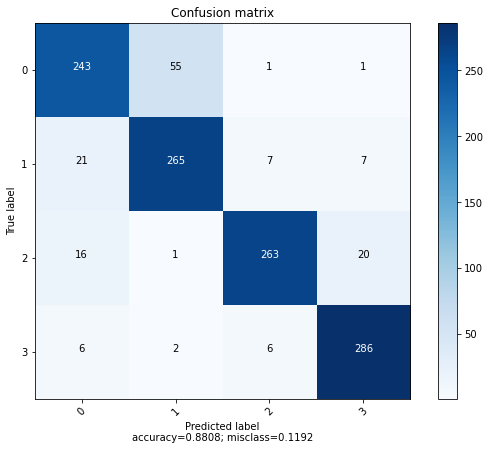

In [18]:
train_model(n_epochs, cnn_cost_list, cnn_accuracy_list)

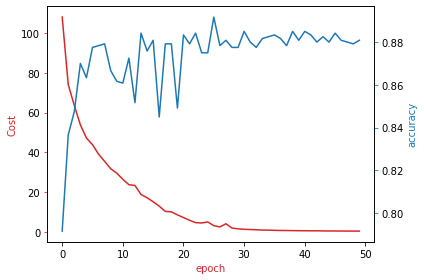

In [19]:
plotSingleModel(cnn_cost_list, cnn_accuracy_list)

In [20]:
torch.cuda.empty_cache()

# Train on Normal dataset and resize 128 without Hilbert

In [25]:
train_dataset = datasets.ImageFolder(root="./train",
                              transform=data_transform)

train_datasets_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)

test_dataset = datasets.ImageFolder(root="./test",
                              transform=data_transform)
test_datasets_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)

In [26]:
model = SimpleCNN(out_1=16, out_2=32)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

n_epochs=50
cnn_cost_list=[]
cnn_accuracy_list=[]

SimpleCNN Model Initialize Successfully!


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 16.73it/s]


epoch0: cost:109.83031445741653 acc:0.8183333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:07<00:00, 19.88it/s]


epoch1: cost:76.65500067174435 acc:0.8208333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:07<00:00, 18.02it/s]


epoch2: cost:63.825169041752815 acc:0.8116666666666666


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.22it/s]


epoch3: cost:55.9852546826005 acc:0.85


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.08it/s]


epoch4: cost:51.09803295880556 acc:0.8766666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.19it/s]


epoch5: cost:44.99950401484966 acc:0.8308333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.04it/s]


epoch6: cost:40.600389931350946 acc:0.8533333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.09it/s]


epoch7: cost:37.3791085369885 acc:0.8741666666666666


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.05it/s]


epoch8: cost:35.39105926826596 acc:0.8633333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.02it/s]


epoch9: cost:32.759827461093664 acc:0.8683333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.17it/s]


epoch10: cost:32.042527072131634 acc:0.8683333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.02it/s]


epoch11: cost:26.191467629745603 acc:0.8808333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.01it/s]


epoch12: cost:25.354515612125397 acc:0.8433333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.18it/s]


epoch13: cost:21.032108586281538 acc:0.865


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.09it/s]


epoch14: cost:21.269616099074483 acc:0.8791666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.12it/s]


epoch15: cost:15.65487611014396 acc:0.8791666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.05it/s]


epoch16: cost:15.061020759865642 acc:0.8825


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.14it/s]


epoch17: cost:12.011188088916242 acc:0.8625


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.20it/s]


epoch18: cost:11.429621522780508 acc:0.8641666666666666


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 16.93it/s]


epoch19: cost:10.524667591322213 acc:0.8591666666666666


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.20it/s]


epoch20: cost:9.72251154994592 acc:0.8691666666666666


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.23it/s]


epoch21: cost:7.703831786115188 acc:0.8616666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.10it/s]


epoch22: cost:8.242694476386532 acc:0.8633333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:07<00:00, 17.55it/s]


epoch23: cost:5.685757480328903 acc:0.8633333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:07<00:00, 18.73it/s]


epoch24: cost:4.91014049644582 acc:0.8583333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 16.64it/s]


epoch25: cost:4.103703182772733 acc:0.8775


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 16.44it/s]


epoch26: cost:3.506945278029889 acc:0.8608333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.32it/s]


epoch27: cost:2.833203223766759 acc:0.87


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.03it/s]


epoch28: cost:2.095643095613923 acc:0.8758333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.25it/s]


epoch29: cost:2.0897307934938 acc:0.8708333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 16.05it/s]


epoch30: cost:1.6227587493485771 acc:0.8716666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.00it/s]


epoch31: cost:1.2088582805590704 acc:0.8783333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.24it/s]


epoch32: cost:1.110569361189846 acc:0.8716666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.13it/s]


epoch33: cost:0.980350777041167 acc:0.8641666666666666


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.32it/s]


epoch34: cost:0.8998355161456857 acc:0.86


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.07it/s]


epoch35: cost:0.823187192727346 acc:0.87


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.04it/s]


epoch36: cost:0.7237904428620823 acc:0.8725


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.15it/s]


epoch37: cost:0.6775326228671474 acc:0.8716666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:06<00:00, 20.40it/s]


epoch38: cost:0.6419662888802122 acc:0.8733333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 16.89it/s]


epoch39: cost:0.578419395867968 acc:0.8741666666666666


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.25it/s]


epoch40: cost:0.5594713233585935 acc:0.8733333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.07it/s]


epoch41: cost:0.49821799440542236 acc:0.8758333333333334


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.27it/s]


epoch42: cost:0.47089968687214423 acc:0.8725


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.00it/s]


epoch43: cost:0.45505947378114797 acc:0.8733333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.07it/s]


epoch44: cost:0.42506255258922465 acc:0.8725


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.20it/s]


epoch45: cost:0.3981223596201744 acc:0.8716666666666667


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 16.85it/s]


epoch46: cost:0.37960302509600297 acc:0.8725


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.26it/s]


epoch47: cost:0.3531094261416001 acc:0.8725


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.20it/s]


epoch48: cost:0.3274613313260488 acc:0.8725


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 17.09it/s]


epoch49: cost:0.3284678451891523 acc:0.8716666666666667
epoch: 49, f1 on test dataset: 0.8715228389143361


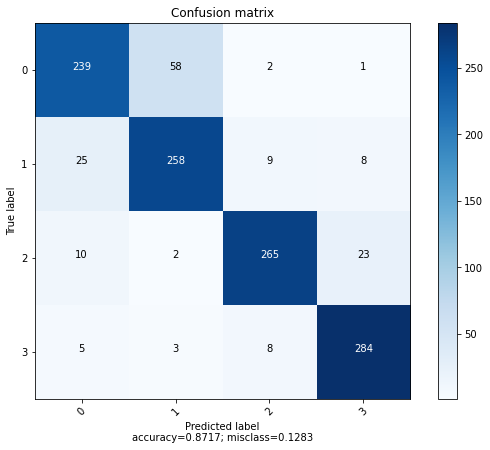

In [27]:
train_model(n_epochs, cnn_cost_list, cnn_accuracy_list)

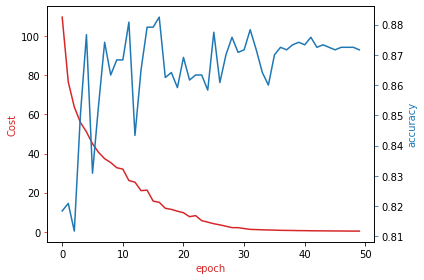

In [28]:
plotSingleModel(cnn_cost_list, cnn_accuracy_list)